# Severstal: Steel Defect Detection

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

## Getting the data

In [3]:
! {sys.executable} -m pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /home/ubuntu/anaconda3/lib/python3.7/site-packages (1.5.6)


In [4]:
! mkdir -p ~/.kaggle/
! mv kaggle.json ~/.kaggle/

mv: cannot stat 'kaggle.json': No such file or directory


In [5]:
path = Config.data_path()/'severstal-steel-defect-detection'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection')

In [6]:
# ! kaggle competitions download -c severstal-steel-defect-detection -f train.csv -p {path}  
# ! kaggle competitions download -c severstal-steel-defect-detection -f train_images.zip -p {path}  
# ! kaggle competitions download -c severstal-steel-defect-detection -f test_images.zip -p {path}  
# ! unzip -q -n {path}/train_images.zip -d {path}/train_images
# ! unzip -q -n {path}/test_images.zip -d {path}/test_images
# ! unzip -q -n {path}/train.csv.zip -d {path}

## Data Ingestion

In [7]:
train_df = pd.read_csv(path/'train.csv')
train_df.head()

,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


# Build SegmentationList

In [8]:
path_img = path/'train_images'

In [9]:
path_lbl = path/'labels'

In [10]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/train_images/cf1152c44.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/train_images/b54038841.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/train_images/1c97d1861.jpg')]

In [11]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/labels/cf1152c44.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/labels/b54038841.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/labels/1c97d1861.jpg')]

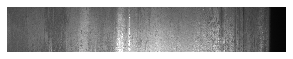

In [12]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

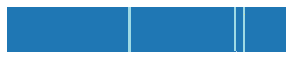

In [13]:
mask = open_mask(lbl_names[0])
mask.show(figsize=(5,5), alpha=1)

In [14]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([ 256, 1600]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [15]:
# src_size = np.array([256,1600])

In [16]:
def process_csv(path, csv):
    
    train_df = pd.read_csv(path/csv)
    
    train_df['label'] = train_df.apply(lambda x : x['ImageId_ClassId'].split('_')[-1], axis=1)
    train_df['image_id'] = train_df.apply(lambda x : x['ImageId_ClassId'].split('_')[0], axis=1)

    proc_train_df = train_df.pivot(index='image_id', columns='label', values='EncodedPixels').reset_index(drop=False)

    proc_train_df = proc_train_df.fillna(value=' ')

#     proc_train_df.to_csv('proc_train.csv', index=False)
    
    return proc_train_df

In [17]:
proc_train_df = process_csv(path, 'train.csv')

In [18]:
proc_train_df.head()

label,image_id,1,2,3,4
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,,,
1,00031f466.jpg,,,,
2,000418bfc.jpg,,,,
3,000789191.jpg,,,,
4,0007a71bf.jpg,,,18661 28 18863 82 19091 110 19347 110 19603 11...,


In [22]:
# os.mkdir(path/'labels')

In [23]:
def make_labels_rle(path, train, proc_train_df, labels):
    for index, row in proc_train_df.iterrows():
        save_rle_label_image(path, row, train, labels)

In [24]:
def save_rle_label_image(path, mask_df, train, labels):
    image_id, rles = mask_df[0], mask_df[1:]
    shape = open_image(path/train/image_id).shape[-2:]
    final_mask = torch.zeros((1, *shape))
    for k, rle in enumerate(rles):
        if isinstance(rle, str):
            mask = open_mask_rle(rle, shape).px.permute(0, 2, 1)
            final_mask += (k+1)*mask
    ImageSegment(final_mask).save(path/labels/image_id)

In [25]:
# make_labels_rle(path, 'train_images', proc_train_df, path_lbl)

In [26]:
codes = [0,1,2,3,4]

In [27]:
get_y_fn = lambda x: path_lbl/f'{x.stem}{x.suffix}'

In [28]:
divisor = 2
numberstuple = (128, 800)

size = tuple(map(lambda x: x//divisor, numberstuple))

In [29]:
get_y_fn(img_f)

PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/labels/cf1152c44.jpg')

In [30]:
# train_list = (SegmentationItemList.
#               from_csv(path, 'new_train.csv', folder=path/'train_images').
#               use_partial_data().
#               split_by_rand_pct(valid_pct=0.2).
#               label_from_df(cols=list(range(5)), label_cls=MultiClassSegList, classes=[0, 1, 2, 3, 4]).
#               transform(size=size, tfm_y=True).
#               databunch(bs=8).
#               normalize(imagenet_stats))

In [31]:
from fastai.utils.mem import *
size = src_size//2
print(size)
free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

[128 800]
using bs=8, have 11430MB of GPU RAM free


In [41]:
data = (SegmentationItemList.from_folder(path_img)
        .split_by_rand_pct(valid_pct=0.2)
        .label_from_func(get_y_fn, classes=codes)
        .transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=1)
        .normalize(imagenet_stats))

In [42]:
# data = (src.transform(get_transforms(), size=[64, 400])
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

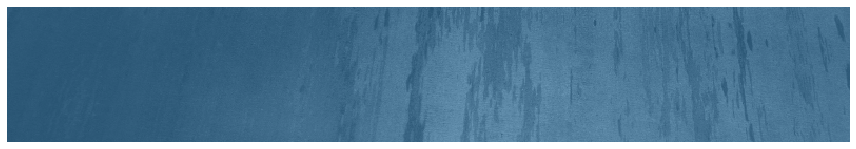

In [43]:
data.show_batch(3, figsize=(12,9))

In [39]:
learn = unet_learner(data, models.resnet34, metrics=[dice])

In [33]:
lr_find(learn)
learn.recorder.plot()

RuntimeError: CUDA error: device-side assert triggered

In [57]:
lr=3e-3

In [58]:
learn.fit_one_cycle(5, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,dice,time


RuntimeError: CUDA out of memory. Tried to allocate 26.00 MiB (GPU 0; 11.17 GiB total capacity; 10.77 GiB already allocated; 20.81 MiB free; 74.12 MiB cached)

In [ ]:
# class MultiClassSegList(SegmentationLabelList):
#     def open(self, id_rles):
#         image_id, rles = id_rles[0], id_rles[1:]
#         shape = open_image(self.path/image_id).shape[-2:]       
#         final_mask = torch.zeros((1, *shape))
#         for k, rle in enumerate(rles):
#             if isinstance(rle, str):
#                 mask = open_mask_rle(rle, shape).px.permute(0, 2, 1)
#                 final_mask += (k+1)*mask
#         return ImageSegment(final_mask)

In [ ]:
# train_list = (SegmentationItemList.
#               from_csv(path, 'new_train.csv', folder=path/'train_images').
#               use_partial_data().
#               split_by_rand_pct(valid_pct=0.2).
#               label_from_df(cols=list(range(5)), label_cls=MultiClassSegList, classes=[0, 1, 2, 3, 4]).
#               transform(size=size, tfm_y=True).
#               databunch(bs=8).
#               normalize(imagenet_stats))

In [70]:
print(size)

(64, 400)


In [134]:
data = load_data(path_img, 'new_train.csv', bs=8, size=size)

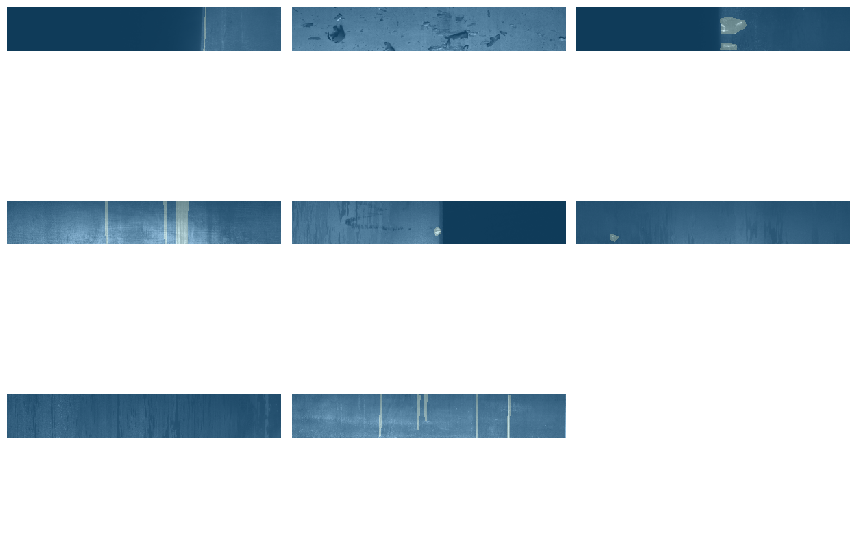

In [135]:
data.show_batch(rows=3, figsize=(12,9))

In [142]:
from fastai.metrics import dice
learn = unet_learner(data, models.resnet34, metrics=[dice])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


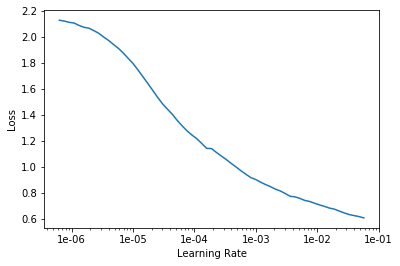

In [143]:
lr_find(learn)
learn.recorder.plot()

In [51]:
print("the number of images with no defects: {}".format(no_defects_num))
print("the number of images with defects: {}".format(defects_num))

the number of images with no defects: 5902
the number of images with defects: 6666


In [61]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/train_images/cf1152c44.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/train_images/b54038841.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/train_images/1c97d1861.jpg')]

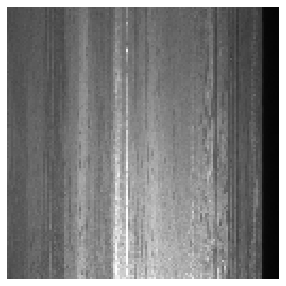

In [65]:
img_f = fnames[0]
img = open_image(img_f).resize((1,128,128))
img.show(figsize=(5,5))

In [ ]:
data = (ImageList.from_csv(planet, path/'train.csv', folder=path/'train_images', suffix='.jpg')
        #Where to find the data? -> in planet 'train' folder
        .split_by_rand_pct()
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_df(label_delim='_')
        #How to label? -> use the second column of the csv file and split the tags by ' '
        .transform(planet_tfms, size=128)
        #Data augmentation? -> use tfms with a size of 128
        .databunch())                          
        #Finally -> use the defaults for conversion to databunch

To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [ ]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

We use parentheses around the data block pipeline below, so that we can use a multiline statement without needing to add '\\'.

In [ ]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [ ]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

`show_batch` still works, and show us the different labels separated by `;`.

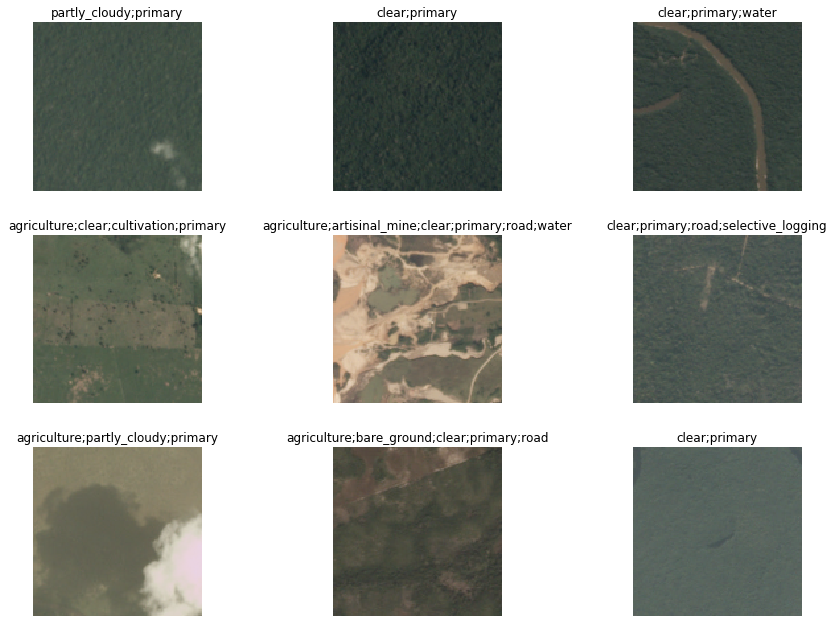

In [ ]:
data.show_batch(rows=3, figsize=(12,9))

To create a `Learner` we use the same function as in lesson 1. Our base architecture is resnet50 again, but the metrics are a little bit differeent: we use `accuracy_thresh` instead of `accuracy`. In lesson 1, we determined the predicition for a given class by picking the final activation that was the biggest, but here, each activation can be 0. or 1. `accuracy_thresh` selects the ones that are above a certain threshold (0.5 by default) and compares them to the ground truth.

As for Fbeta, it's the metric that was used by Kaggle on this competition. See [here](https://en.wikipedia.org/wiki/F1_score) for more details.

In [ ]:
arch = models.resnet50

In [ ]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/ubuntu/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 100859665.66it/s]


We use the LR Finder to pick a good learning rate.

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


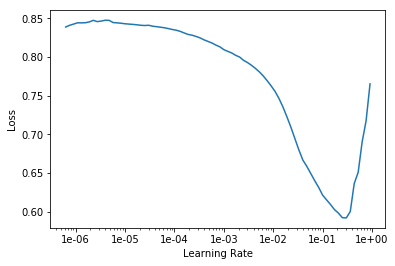

In [ ]:
learn.recorder.plot()

Then we can fit the head of our network.

In [ ]:
lr = 0.01

In [ ]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.125128,0.110038,0.944010,0.904893
2,0.112533,0.101303,0.955964,0.910774
3,0.100574,0.093255,0.955187,0.918653
4,0.096056,0.087997,0.954983,0.924016
5,0.092320,0.086761,0.956400,0.925110


In [ ]:
learn.save('stage-1-rn50')

...And fine-tune the whole model:

In [ ]:
learn.unfreeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


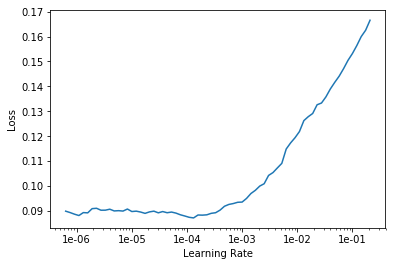

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.097016,0.094868,0.952004,0.916215
2,0.095774,0.088899,0.954540,0.922340
3,0.090646,0.085958,0.959249,0.924921
4,0.085097,0.083291,0.958849,0.928195
5,0.079197,0.082855,0.958602,0.928259


In [ ]:
learn.save('stage-2-rn50')

In [ ]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [ ]:
learn.freeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


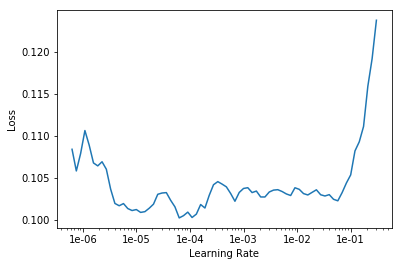

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr=1e-2/2

In [ ]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.087761,0.085013,0.958006,0.926066
2,0.087641,0.083732,0.958260,0.927459
3,0.084250,0.082856,0.958485,0.928200
4,0.082347,0.081470,0.960091,0.929166
5,0.078463,0.080984,0.959249,0.930089


In [ ]:
learn.save('stage-1-256-rn50')

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.082938,0.083548,0.957846,0.927756
2,0.086312,0.084802,0.958718,0.925416
3,0.084824,0.082339,0.959975,0.930054
4,0.078784,0.081425,0.959983,0.929634
5,0.074530,0.080791,0.960426,0.931257


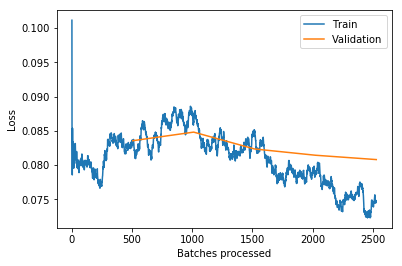

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage-2-256-rn50')

You won't really know how you're going until you submit to Kaggle, since the leaderboard isn't using the same subset as we have for training. But as a guide, 50th place (out of 938 teams) on the private leaderboard was a score of `0.930`.

In [ ]:
learn.export()

## fin

(This section will be covered in part 2 - please don't ask about it just yet! :) )

In [ ]:
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}  
#! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z -p {path}  
#! 7za -bd -y -so x {path}/test-jpg-additional.tar.7z | tar xf - -C {path}

In [ ]:
test = ImageList.from_folder(path/'test-jpg').add(ImageList.from_folder(path/'test-jpg-additional'))
len(test)

61191

In [ ]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [ ]:
labelled_preds[:5]

['agriculture cultivation partly_cloudy primary road',
 'clear haze primary water',
 'agriculture clear cultivation primary',
 'clear primary',
 'partly_cloudy primary']

In [ ]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [ ]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])

In [ ]:
df.to_csv(path/'submission.csv', index=False)

In [ ]:
! kaggle competitions submit planet-understanding-the-amazon-from-space -f {path/'submission.csv'} -m "My submission"

100%|██████████████████████████████████████| 2.18M/2.18M [00:02<00:00, 1.05MB/s]
Successfully submitted to Planet: Understanding the Amazon from Space

Private Leaderboard score: 0.9296 (around 80th)